# Entropy Estimator - Histogram

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(pysim_root))

import numpy as np
import jax
import jax.numpy as jnp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
# %load_ext lab_black

## Demo Data - Gaussian

In [3]:
from pysim.data.information.studentt import generate_studentt_data
from pysim.data.information.gaussian import generate_gaussian_data

# parameters
n_samples = 1_000
n_features = 1
df = 10

# create seed (trial number)
# res_tuple = generate_studentt_data(n_samples=n_samples, n_features=n_features, df=df)
res_tuple = generate_gaussian_data(n_samples=n_samples, n_features=n_features)

H_true = res_tuple.H

print(f"True Estimator: {H_true:.4f} nats")

True Estimator: 1.5448 nats


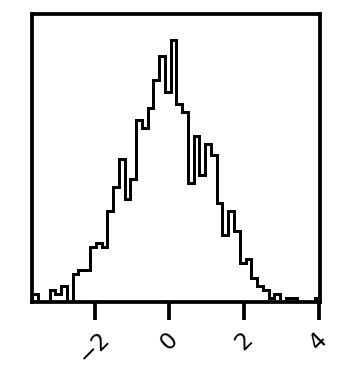

In [4]:
fig = corner.corner(res_tuple.X, bins=50)

## Histogram

In [5]:
# import numpy as np
# from scipy.stats import rv_histogram

# # histogram parameters
# nbins = "auto"
# data = res_tuple.X.copy()
# data_marginal = data[:, 0]

# # get histogram
# histogram = np.histogram(data_marginal, bins=nbins)

# # create histogram random variable
# hist_dist = rv_histogram(histogram)

Many times we call for an empirical estimator:

$$
\hat{H}_{MLE}(p_N) = - \sum_{i}^{m}p_{N,i} \log p_{N,i}
$$

where $\hat{p}_k=\frac{h_k}{n}$ are the maximum likelihood estimates of each probability $p_k$ and $h_k=\sum_{i}^n\boldsymbol{1}_{\{X_i=k\}}$


**Resources**:

* Antos & Kontoyiannis (2001) - "plug-in" estimator
* Strong et. al. (1998) - "naive" estimator


Fortunately, the scipy method already does this for us.

#### From Scratch

#### 1. Histogram

In [6]:
# histogram parameters
nbins = "auto"
data = res_tuple.X.copy()


# get hist counts and bin edges

data_min = data.min() #- 0.1
data_max = data.max() #+ 0.1
n_samples = data.shape[0]
bins = int(jnp.sqrt(n_samples))

counts, bin_edges = jnp.histogram(data, bins=bins, range=(data_min, data_max), density=False)

**Note**:

It's always good practice to leave a bit of room for the boundaries.

#### 2. Get Bin Centers

In the numpy implementation, we are only given the `bin_edges` and we need to `bin_centers`. It's a minor thing but it's important in order to get the width between each of the 

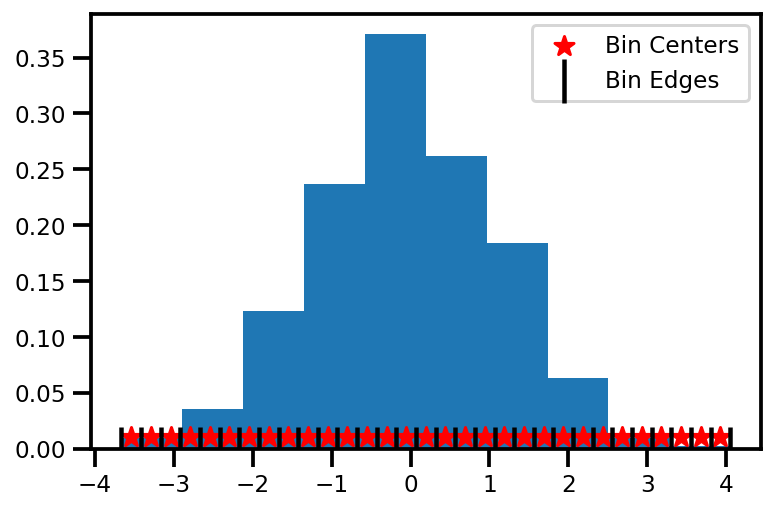

In [7]:
# get the bin centers
bin_centers = jnp.mean(jnp.vstack((bin_edges[0:-1], bin_edges[1:])), axis=0)

delta = bin_centers[3] - bin_centers[2]

# visualize
fig, ax = plt.subplots()
ax.hist(data, bins=10, density=True)
ax.scatter(bin_centers, 0.01 * np.ones_like(bin_centers), marker="*", s=100, zorder=4, color='red', label="Bin Centers")
ax.scatter(bin_edges, np.zeros_like(bin_edges), marker="|", s=500, zorder=4, color='black', label="Bin Edges")
plt.legend()
plt.show()

#### 4. Get Normalized Density

In [8]:
# get the normalized density
pk = 1.0 * jnp.array(counts) / jnp.sum(counts)

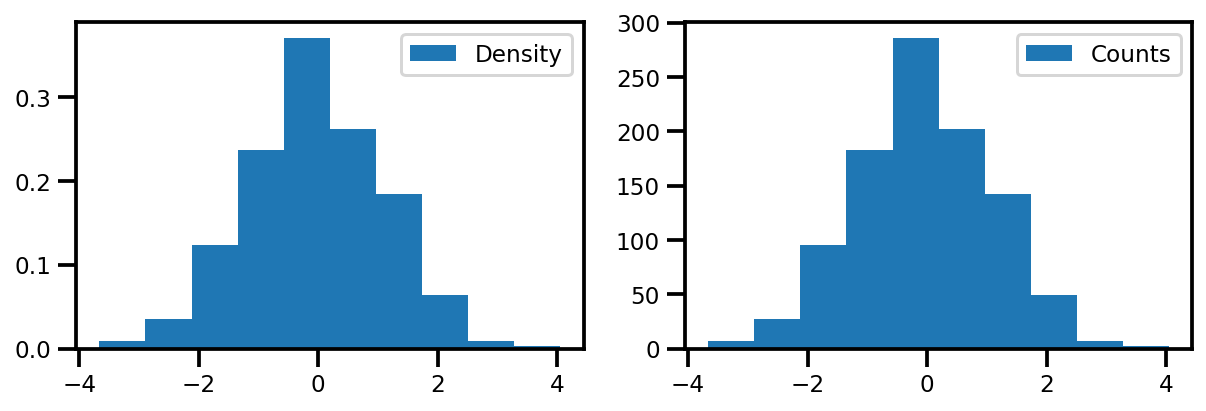

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].hist(data, bins=10, density=True)
ax[0].legend(["Density"])
ax[1].hist(data, bins=10, density=False)
ax[1].legend(["Counts"])
plt.show()

#### 5. Calculate Entropy given the probability

In [10]:
# manually
H = 0.0

for ip_k in pk:
    
    if ip_k > 0.0:
        
        H += - ip_k * jnp.log(ip_k)

H += jnp.log(delta)

# H += np.log(delta)
print(f"MLE Estimator: {H:.4f} nats")
print(f"True Estimator: {H_true:.4f} nats")

MLE Estimator: 1.5379 nats
True Estimator: 1.5448 nats


In [11]:

# refactored
from jax.scipy.special import entr

H_vec = entr(pk)
H_vec = jnp.sum(H_vec)
H_vec += jnp.log(delta)

np.testing.assert_almost_equal(H, H_vec)

#### Refactor - Scipy

In [12]:
from scipy.stats import rv_histogram

histogram = np.histogram(data, bins=bins, range=(data_min, data_max), density=False)

hist_dist = rv_histogram(histogram)

H_mle = hist_dist.entropy()

np.testing.assert_almost_equal(H_mle, H_vec, decimal=6)

print(f"Scipy Estimator: {H_mle:.4f} nats")
print(f"My Estimator: {H:.4f} nats")
print(f"True Estimator: {H_true:.4f} nats")

Scipy Estimator: 1.5379 nats
My Estimator: 1.5379 nats
True Estimator: 1.5448 nats


It's known in the community that this will under estimate the probability distribution. 

**Resources**:

* [Blog Post](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html) - Sebasian Nowozin (2015)

### Corrections

#### Miller-Maddow

$$
\hat{H}_{MM}(p_N) = \hat{H}_{MLE}(p_N) + \frac{\hat{m}-1}{2N}
$$

where $\hat{m}$ are the number of bins with non-zero $p_N$ probability.

In [14]:
# get histogram counts
hist_counts = histogram[0]

total_counts = np.sum(hist_counts)
total_nonzero_counts = np.sum(hist_counts > 0)

N = data.shape[0]

# get correction
mm_correction = 0.5 * (np.sum(hist_counts > 0) - 1) / np.sum(hist_counts)
print(mm_correction)

0.0145


In [15]:
total_counts, total_nonzero_counts

(1000, 30)

In [16]:
H_mm = H + mm_correction

print(f"My Estimator:\n{H:.4f} nats")
print(f"Miller-Maddow Estimator:\n{H_mm:.4f} nats")
print(f"True Estimator:\n{H_true:.4f} nats")

My Estimator:
1.5379 nats
Miller-Maddow Estimator:
1.5524 nats
True Estimator:
1.5448 nats


### Custom Function

In [47]:
from chex import Array
from typing import Callable, Tuple, Union

def get_domain_extension(
    data: Array, extension: Union[float, int],
) -> Tuple[float, float]:
    """Gets the extension for the support
    
    Parameters
    ----------
    data : Array
        the input data to get max and minimum

    extension : Union[float, int]
        the extension
    
    Returns
    -------
    lb : float
        the new extended lower bound for the data
    ub : float
        the new extended upper bound for the data
    """

    # case of int, convert to float
    if isinstance(extension, int):
        extension = float(extension / 100)

    # get the domain
    domain = jnp.abs(jnp.max(data) - jnp.min(data))

    # extend the domain
    domain_ext = extension * domain

    # get the extended domain
    lb = jnp.min(data) - domain_ext
    up = jnp.max(data) + domain_ext

    return lb, up

def histogram_jax_entropy(data: Array, bin_est_f: Callable, extension: Union[float, int]=10):
    
    # get extension
    lb, ub = get_domain_extension(data, extension)
    
    # histogram bin width
    bin_width = bin_est_f(data)
    
    # histogram bins
    nbins = get_num_bins(data, bin_width, lb, ub)
    
    # histogram
    counts, bin_edges = jnp.histogram(data, bins=nbins, density=False)
    
    # get the normalized density
    pk = 1.0 * jnp.array(counts) / jnp.sum(counts)
    
    # get delta
    delta = bin_edges[3] - bin_edges[2]
    
    # calculate entropy
    H = entr(pk)
    H = jnp.sum(H)
    
    H += jnp.log(delta)
    
    return H
from chex import Array
import math

def hist_bin_scott(x: Array) -> Array:
    """Optimal histogram bin width based on scotts method.
    Uses the 'normal reference rule' which assumes the data
    is Gaussian

    Parameters
    ----------
    x : Array
        The input array, (n_samples)

    Returns
    -------
    bin_width : Array
        The optimal bin width, ()
    """
    n_samples = x.shape[0]
#     print(3.5 * np.std(x) / (n_samples ** (1/3)))
    return (24.0 * math.pi ** 0.5 / n_samples) ** (1.0 / 3.0) * jnp.std(x)
def get_num_bins(data, bin_width, data_min, data_max):
    nbins = jnp.ceil((data_max - data_min) / bin_width)
    nbins = jnp.maximum(1, nbins).astype(jnp.int32)

    bins = data_min + bin_width * jnp.arange(0, nbins+1, 1)
    return nbins

In [20]:
import jax.numpy as jnp
from jax.scipy.special import entr

def histogram_entropy(data, bins=None):
    """Estimate univariate entropy with a histogram
    
    Notes
    -----
    * uses scott's method
    * entropy is in nats
    """
    # histogram bin width (scotts)
    bin_width = 3.5 * jnp.std(data) / (data.shape[0] ** (1/3))
    
    if bins is None:
        # histogram bins
        nbins = jnp.ceil((data.max() - data.min()) / bin_width)
        nbins = nbins.astype(jnp.int32)

        # get bins with linspace
        bins = jnp.linspace(data.min(), data.max(), nbins)

#         # bins with arange (similar to astropy)
#         bins = data_min + bin_width * jnp.arange(0, nbins+1, 1)

    # histogram
    counts, bin_edges = jnp.histogram(data, bins=bins, density=False)
    
    # normalized the bin counts for a density
    pk = 1.0 * jnp.array(counts) / jnp.sum(counts)
    
    # calculate entropy
    H = entr(pk)
    H = jnp.sum(H)
    
    # add correction for continuous case
    delta = bin_edges[3] - bin_edges[2]
    H += jnp.log(delta)
    
    return H

In [21]:
import numpy as np
import jax

data = np.random.randn(1_000)
data = jnp.array(data, dtype=jnp.float32)

histogram_entropy(jnp.array(data).ravel(), 10)

DeviceArray(1.4400792, dtype=float32)

In [23]:
f = jax.jit(jax.partial(histogram_entropy, bins=None))

f(data.ravel())

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>
'num' argument of jnp.linspace
While tracing the function histogram_entropy at <ipython-input-20-58a03409a594>:4, this concrete value was not available in Python because it depends on the value of the arguments to histogram_entropy at <ipython-input-20-58a03409a594>:4 at flattened positions [0], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).
 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError)

## Bin Width

In [144]:
def get_bins(data, bin_width, data_min, data_max):
    nbins = jnp.ceil((data_max - data_min) / bin_width)
    nbins = jnp.maximum(1, nbins)
    bins = jnp.linspace(data_min, data_max, nbins+1)
#     bins = data_min + bin_width * jnp.arange(start=0.0, stop=nbins + 1)
    return bins

In [143]:
nbins = jnp.ceil((data_max - data_min) / bin_width)
nbins = jnp.maximum(1, nbins)
print(nbins)
# data_min + bin_wijnp.arange(start=0.0, stop=nbins+1)

17.0


NameError: name 'bin_wijnp' is not defined

In [140]:
def get_histogram_entropy(data, bins):
    
    histogram = jnp.histogram(data, bins=bins,density=False)
    
    hist_dist = rv_histogram(histogram)

    H_mle = hist_dist.entropy()
    
    print(f"MLE Estimator: {H_mle:.4f} nats")

In [141]:
bins = get_bins(data, 0.5, data_min, data_max)


get_histogram_entropy(data, bins)

TypeError: only integer scalar arrays can be converted to a scalar index

### Scotts

$$
\Delta_b = 3.5\sigma n^{-\frac{1}{3}}
$$

where $\sigma$ is the standard deviation and $n$ is the number of samples.

In [71]:
from chex import Array
import math

def hist_bin_scott(x: Array) -> Array:
    """Optimal histogram bin width based on scotts method.
    Uses the 'normal reference rule' which assumes the data
    is Gaussian

    Parameters
    ----------
    x : Array
        The input array, (n_samples)

    Returns
    -------
    bin_width : Array
        The optimal bin width, ()
    """
    n_samples = x.shape[0]
#     print(3.5 * np.std(x) / (n_samples ** (1/3)))
    return (24.0 * math.pi ** 0.5 / n_samples) ** (1.0 / 3.0) * jnp.std(x)

In [72]:
bin_width = hist_bin_scott(data)

bins = get_bins(data, bin_width, data_min, data_max)


get_histogram_entropy(data, bins)

MLE Estimator: 1.6740 nats


### Freedman

In [ ]:
def hist_bin_freedman(x: Array) -> Array:
    """Optimal histogram bin width based on scotts method.
    Uses the 'normal reference rule' which assumes the data
    is Gaussian

    Parameters
    ----------
    x : Array
        The input array, (n_samples)

    Returns
    -------
    bin_width : Array
        The optimal bin width, ()
    """
    n_samples = x.shape[0]
#     print(3.5 * np.std(x) / (n_samples ** (1/3)))
    return (24.0 * math.pi ** 0.5 / n_samples) ** (1.0 / 3.0) * jnp.std(x)

### Silverman

### Gaussian

#### 

### Volume

In [3]:
def volume_unit_ball(d_dimensions: int, norm=2) -> float:
    """Volume of the unit l_p-ball in d-dimensional

    Parameters
    ----------
    d_dimensions : int
        Number of dimensions to estimate the volume

    norm : int, default=2
        The type of ball to get the volume.
        * 2 : euclidean distance
        * 1 : manhattan distance
        * 0 : chebyshev distance

    Returns
    -------
    vol : float
        The volume of the d-dimensional unit ball

    References
    ----------
    [1]:    Demystifying Fixed k-Nearest Neighbor Information 
            Estimators - Gao et al (2016)
    """

    # get ball
    if norm == 0:
        return 1.0
    elif norm == 1:
        raise NotImplementedError()
    elif norm == 2:
        b = 2.0
    else:
        raise ValueError(f"Unrecognized norm: {norm}")

    numerator = gamma(1.0 + 1.0 / b) ** d_dimensions
    denomenator = gamma(1.0 + d_dimensions / b)
    vol = 2 ** d_dimensions * numerator / denomenator

    return vol